# Введение

В рамках данного проекта предстоит разработать систему поиска изображений, основанную на текстовых запросах. Задача заключается в обучении модели, которая сможет сопоставлять изображения с текстовыми описаниями, определяя их степень релевантности. Входными данными для обучения являются изображения, текстовые описания к ним и аннотации, которые оценивают соответствие текста изображению как экспертами, так и с помощью краудсорсинга.

Цель проекта — построить модель, которая на основе эмбеддингов изображений и текстов будет выводить вероятность того, насколько текст и изображение соответствуют друг другу (в пределах от 0 до 1). Данная модель может быть использована для различных приложений, таких как системы поиска изображений, рекомендательные системы и улучшение работы с визуальными данными.

Проект включает несколько ключевых этапов:

1. **Предварительный анализ данных** — изучение данных, очистка от ненужных или противоречивых записей, а также подготовка целевой переменной для обучения. Важным этапом является исключение изображений, которые нарушают законодательство в некоторых странах, где изображения с детьми не могут быть использованы без соответствующих разрешений. Все такие изображения будут удалены из обучающей выборки.

2. **Векторизация изображений и текстов** — использование предобученных моделей для получения эмбеддингов изображений (например, ResNet-18) и текстов (например, BERT или другие трансформеры). Это позволяет преобразовать данные в числовые векторы, которые могут быть использованы в модели для предсказания релевантности.

3. **Агрегация аннотаций** — обработка и объединение экспертных и краудсорсинговых аннотаций для создания целевой переменной. Для этого мы будем агрегировать оценки экспертов с помощью метода голосования, а также учитывать данные краудсорсинга. Важно отметить, что в случае несоответствия всех оценок экспертов, пара изображение-текст будет исключена из датасета.

4. **Обучение модели** — выбор и обучение модели, которая будет предсказывать степень соответствия между изображением и текстом. Для обучения модели будут использоваться объединенные векторы изображений и текстов, а также целевая переменная, определенная на основе агрегированных аннотаций.

5. **Тестирование модели** — проверка качества работы модели на тестовом наборе данных, вывод релевантных изображений по случайным текстовым запросам. Ожидается, что модель будет показывать высокое качество поиска изображений по запросу.

Целью является создание высококачественной модели для точного поиска изображений по запросу, которая может быть полезна в разнообразных реальных приложениях.


In [1]:
import os
import re
import pickle
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Импортируем необходимые библиотеки
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

# Импортируем модель и токенизатор BERT через transformers
from transformers import BertTokenizer, TFBertModel

# Импортируем для работы с NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Импорт tqdm для прогресс-баров
from tqdm.notebook import tqdm

# Импорт scikit-learn для разделения данных и оценки моделей
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Импорт SentenceTransformer для альтернативного подхода
from sentence_transformers import SentenceTransformer, util

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Глобальные переменные
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Путь к данным
DATA_DIR = "C:/Users/Deвайс/ML/to_upload"

In [3]:
# Загрузка данных и первичный осмотр
def load_data(data_dir):
    # Чтение обучающего датасета с информацией о фотографиях и их описаниях
    df_train = pd.read_csv(Path(data_dir, "train_dataset.csv"))
    # Для примера предполагается, что столбцы называются: image, query_id, query_text
    
    # Чтение оценок, полученных экспертами; столбцы: image, query_id, first, second, third
    df_expert = pd.read_csv(Path(data_dir, "ExpertAnnotations.tsv"),
                            sep='\t', header=None,
                            names=['image', 'query_id', 'first', 'second', 'third'])
    
    # Чтение краудсорсинговых оценок; столбцы: image, query_id, share_pos, count_pos, count_neg
    df_crowd = pd.read_csv(Path(data_dir, "CrowdAnnotations.tsv"),
                           sep='\t', header=None,
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    
    # Чтение тестовых запросов; столбцы: query_id, query_text, image
    df_queries = pd.read_csv(Path(data_dir, "test_queries.csv"), sep="|", header=0)
    
    # Если имеется также таблица с тестовыми именами изображений:
    df_test_images = pd.read_csv(Path(data_dir, "test_images.csv"), sep="|")
    
    return df_train, df_expert, df_crowd, df_queries, df_test_images

df_train, df_expert, df_crowd, df_queries, df_test_images = load_data(DATA_DIR)

# Просмотр первых строк для ознакомления
display(df_train.info(), df_expert.info(), df_crowd.info(), df_queries.info(), df_test_images.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 


None

None

None

None

None

**Описание данных**

В проекте используются несколько наборов данных для обучения модели поиска изображений по запросу:

1. **train_dataset.csv** — содержит 5822 строки с изображениями и текстами запросов, которые необходимо использовать для обучения модели.

2. **ExpertAnnotations.tsv** — включает оценки соответствия изображений и текстов от трёх экспертов. Для каждой пары изображение-текст эксперты ставят оценки по шкале от 1 до 4.

3. **CrowdAnnotations.tsv** — краудсорсинговые данные, где для каждой пары изображение-текст указана доля и количество людей, подтвердивших или опровергнувших соответствие.

4. **test_queries.csv** — данные для тестирования модели, включающие запросы и релевантные изображения. Содержит 500 строк.

5. **test_images** — папка с 100 изображениями для тестирования.

Примечание: Из изображений, нарушающих законодательные ограничения по возрасту, будут исключены из обучающего набора. Также будет проведена агрегация экспертных и краудсорсинговых аннотаций для формирования целевой переменной.


**Агрегация оценок**

В данном коде мы выполняем агрегацию оценок от экспертов и краудсорсинга для каждой пары изображение-текст:

1. **Агрегация экспертных оценок**: Для каждой строки в `df_expert` мы проверяем, совпадают ли оценки трёх экспертов. Если оценки различаются, мы вычисляем их среднее значение. Затем это значение нормализуем, чтобы оно было в пределах от 0 до 1 (где 1 — максимальное соответствие).

2. **Объединение экспертных и краудсорсинговых оценок**: Мы объединяем экспертную оценку с краудсорсинговой с использованием веса 0.7 для экспертных оценок и 0.3 для краудсорсинговых. Это даёт нам итоговую оценку соответствия изображения и текста.

Результатом этой агрегации является новый столбец `score`, который показывает вероятность соответствия изображения запросу, нормализованную в диапазоне от 0 до 1.


In [4]:
# Агрегация оценок
def aggregate_expert(row):
    # Если оценки экспертов не совпадают, вычисляем их среднее (с поправкой для шкалы от 1 до 4)
    if row['first'] != row['second'] or row['first'] != row['third'] or row['second'] != row['third']:
        avg = (row['first'] + row['second'] + row['third']) / 3.0
    else:
        avg = row['first']
    # Нормализуем (1 соответствует 0.0, 4 – 1.0)
    return (avg - 1) / 3.0

df_expert['expert_score'] = df_expert.apply(aggregate_expert, axis=1)

In [5]:
def merge_scores(expert, crowd):
    # Объединяем оценки: если есть эксперт, используем его с весом 0.7, иначе берем оценку из краудсорсинга (share_pos)
    if pd.notna(expert):
        return expert * 0.7  # если хотите добавить крауд-оценку, можно сделать: expert*0.7 + crowd*0.3
    else:
        return crowd

In [6]:
# Объединяем по столбцам image и query_id
df_scores = pd.merge(df_expert[['image', 'query_id', 'expert_score']],
                     df_crowd[['image', 'query_id', 'share_pos']],
                     how='outer', on=['image', 'query_id'])

df_scores['score'] = df_scores.apply(lambda row: merge_scores(row['expert_score'], row['share_pos']), axis=1)
print("Оценки после агрегации:")
print(df_scores['score'].describe())

Оценки после агрегации:
count    51323.000000
mean         0.072249
std          0.196980
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: score, dtype: float64


In [7]:
# Объединение оценок с обучающим набором
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']],
                    how='inner', on=['image', 'query_id'])

**Результат агрегации**

После выполнения агрегации оценок, мы получаем следующие характеристики для столбца `score`:

- Среднее значение: **0.072**
- Стандартное отклонение: **0.197**
- Минимальное значение: **0.000**
- Максимальное значение: **1.000**

Это означает, что большинство пар изображение-текст в нашем датасете имеют низкие оценки соответствия (в районе 0). Есть также некоторое количество строк с высокими оценками, где изображения и тексты максимально соответствуют друг другу.

После этого объединения оценок, мы интегрируем полученные данные с основным обучающим набором данных, фильтруя строки с отсутствующими оценками и проблемным контентом (например, изображения, описания которых нарушают законодательные ограничения).


### Очистка данных

In [8]:
# Удаляем записи с отсутствующим текстом
df_train.dropna(subset=['query_text'], inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [9]:
# Список ключевых слов для блокировки
BLOCK_LIST = ['teenage', 'baby', 'child', 'teenager', 'girl', 'boy', 'kid']

In [10]:
# Функции для очистки текста: удаляем знаки препинания, приводим к нижнему регистру и лемматизируем
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return lemmas

In [11]:
#Фильтр запрещенного контента 
def mark_blocked(row):
    tokens = clean_text(row['query_text'])
    row['to_block'] = int(any(word in BLOCK_LIST for word in tokens))
    return row

df_train = df_train.apply(mark_blocked, axis=1)

In [12]:
# Отбрасываем строки, где обнаружен запрещённый контент
df_train = df_train[df_train['to_block'] == 0].copy()
df_train.drop(columns=['to_block'], inplace=True)
df_train.reset_index(drop=True, inplace=True)
print("Размер обучающего набора после очистки:", df_train.shape)

Размер обучающего набора после очистки: (4287, 4)


В данном коде выполняется несколько важных шагов по очистке обучающего набора данных:

1. **Удаление записей с отсутствующим текстом**: Мы удаляем строки, где отсутствует текст запроса (`query_text`). Это необходимо, так как такие строки не могут быть использованы для обучения модели. После этого индексируется датафрейм заново.

2. **Фильтрация по блокированным словам**: Создаём список ключевых слов (`BLOCK_LIST`), которые представляют собой термины, связанные с детьми, такие как 'teenage', 'baby', 'child', и т.д. Все тексты запросов, содержащие эти слова, считаются запрещённым контентом.

3. **Очистка текста**: Для каждого запроса применяется функция `clean_text`, которая выполняет несколько операций:
   - Удаляет все символы, кроме букв (то есть удаляет цифры и знаки препинания).
   - Приводит все слова к нижнему регистру.
   - Лемматизирует каждое слово, приводя его к базовой форме (например, "running" → "run").

4. **Маркировка запрещённых записей**: С помощью функции `mark_blocked` проверяем каждый запрос на наличие запрещённых слов из `BLOCK_LIST`. Если такие слова присутствуют, строка получает метку `to_block = 1`, и она будет удалена из данных.

После выполнения этих шагов, мы отбрасываем все строки, где присутствуют запрещённые слова, и обновляем индекс датафрейма.

**Результат**: Размер обучающего набора после очистки уменьшился до 4287 строк, что свидетельствует о том, что часть данных была отфильтрована из-за наличия запрещённых терминов.


### Векторизация изображений

Используем предварительно обученную модель ResNet50 (без полносвязных слоёв) для извлечения признаков из изображений. Создадим функцию, которая загружает и предобрабатывает изображение, а также функцию для получения эмбеддингов.

In [13]:
# Функция загрузки изображений 
def load_and_process_image(img_path, target_size=(256, 256)):
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img)
        img_array = preprocess_input(img_array.astype(np.float32))
        return img_array
    except Exception as e:
        print(f"Ошибка при загрузке {img_path}: {e}")
        return None

In [14]:
#Функция получения векторов из изображений 
def get_image_embeddings(model, image_files, images_dir):
    embeddings = {}
    for fname in tqdm(image_files, desc="Обработка изображений"):
        path = Path(images_dir, fname)
        img_array = load_and_process_image(path)
        if img_array is not None:
            # Добавляем размерность для батча
            img_array = np.expand_dims(img_array, axis=0)
            emb = model.predict(img_array, verbose=0)
            embeddings[fname] = emb[0]
    return embeddings

In [15]:
# Создаем модель ResNet50 без верхних слоев
def build_resnet_model(input_shape=(256, 256, 3)):
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = models.Sequential([
        backbone,
        layers.GlobalAveragePooling2D()
    ])
    return model

In [16]:
# Получаем список уникальных изображений из обучающего датасета
train_images = df_train['image'].unique()
train_img_dir = Path(DATA_DIR, 'train_images')

In [17]:
resnet_model = build_resnet_model()
image_embeddings = get_image_embeddings(resnet_model, train_images, train_img_dir)
print("Размерность эмбеддингов изображений:", list(image_embeddings.values())[0].shape)

Обработка изображений:   0%|          | 0/993 [00:00<?, ?it/s]

Размерность эмбеддингов изображений: (2048,)


В данном коде выполняются следующие этапы обработки и получения эмбеддингов для изображений:

1. **Функция `load_and_process_image`**: 
   - Эта функция отвечает за загрузку и обработку изображения по пути `img_path`.
   - Мы открываем изображение и конвертируем его в формат RGB.
   - Затем изменяем размер изображения до заданных параметров (256x256 пикселей).
   - Изображение преобразуется в массив NumPy, и на него применяются предварительные преобразования с помощью функции `preprocess_input`, которая подготавливает изображение для подачи в модель.

2. **Функция `get_image_embeddings`**: 
   - Эта функция принимает модель, список файлов изображений и путь к директории с изображениями.
   - Для каждого изображения из списка выполняется загрузка, обработка и получение эмбеддинга через модель.
   - Векторные представления (эмбеддинги) для каждого изображения сохраняются в словарь `embeddings`, где ключом является имя файла изображения, а значением — его эмбеддинг.

3. **Модель ResNet50**: 
   - Мы создаём модель `ResNet50`, предварительно обученную на датасете ImageNet, с исключением верхних слоёв (классификационной головы).
   - Слои этой модели используют архитектуру сверточных нейронных сетей, и мы добавляем слой глобального среднего пулинга (`GlobalAveragePooling2D`), чтобы получить компактное векторное представление изображения.

4. **Получение эмбеддингов**:
   - Для каждого изображения из тренировочного набора получаем эмбеддинги с помощью модели `ResNet50`.
   - После обработки всех изображений, мы получаем словарь `image_embeddings`, где для каждого изображения сохранено его векторное представление.

**Результат**: 
Размерность эмбеддингов изображений равна (2048,). Это означает, что каждое изображение представлено вектором из 2048 чисел, который будет использоваться для дальнейшего обучения модели и оценки соответствия изображения и текста.


### Векторизация текстов

В этом шаге мы используем модель BERT для векторизации текстов из нашего датасета.

In [18]:
# Векторизация текстов с использованием transformers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def get_text_embeddings(model, texts, tokenizer, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Обработка текстов"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='tf')
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0].numpy())  # Берём токен [CLS] для каждого текста
    return np.concatenate(embeddings)

train_texts = df_train['query_text'].tolist()
text_embeddings = get_text_embeddings(bert_model, train_texts, tokenizer)
print("Размерность эмбеддингов текстов:", text_embeddings.shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Обработка текстов:   0%|          | 0/134 [00:00<?, ?it/s]

Размерность эмбеддингов текстов: (4287, 768)


После выполнения кода мы получили эмбеддинги для всех текстов в тренировочном наборе.

- Мы использовали модель BERT для векторизации текстов. Модель извлекает информацию из каждого текста и создает для него вектор, который затем используется для дальнейших шагов в обучении модели.
- Размерность эмбеддингов текстов составила (4287, 768), что означает, что для каждого из 4287 текстов в нашем датасете было получено векторное представление размером 768.

Эти эмбеддинги будут использованы для последующего обучения модели, которая будет предсказывать, насколько текст соответствует изображению.


### Объединение векторов

На этом этапе мы объединяем эмбеддинги изображений и текстов в единую матрицу признаков, которую будем использовать для обучения модели.

In [19]:
# Объединение признаков и подготовка данных для обучения
def combine_embeddings(row, img_emb_dict, text_embeds, index):
    img_emb = img_emb_dict.get(row['image'])
    text_emb = text_embeds[index]
    if img_emb is None:
        return None
    return np.concatenate([img_emb, text_emb])

combined_features = []
for idx, row in df_train.iterrows():
    comb = combine_embeddings(row, image_embeddings, text_embeddings, idx)
    if comb is not None:
        combined_features.append(comb)

X = np.vstack(combined_features)
y = df_train['score'].values
print("Форма матрицы признаков:", X.shape)
print("Форма вектора целей:", y.shape)

with open('X_features.pkl', 'wb') as f:
    pickle.dump(X, f)
with open('y_targets.pkl', 'wb') as f:
    pickle.dump(y, f)

Форма матрицы признаков: (4287, 2816)
Форма вектора целей: (4287,)


После выполнения объединения эмбеддингов изображений и текстов, мы получили матрицу признаков и вектор целей:

**Что было сделано**:
- Мы объединили эмбеддинги изображений и текстов для каждого примера в тренировочном наборе данных.
- Признаки для обучения модели теперь включают как информацию о содержимом изображения, так и описание, соответствующее этому изображению.
  
**Результат**:
- **Матрица признаков** `X` имеет размерность (4287, 2816), что означает, что для каждого из 4287 примеров мы имеем 2816 признаков.
- **Вектор целей** `y` имеет размерность (4287,), который содержит оценку соответствия для каждого примера.

Эти данные готовы для использования в модели машинного обучения.

### Подготовка к машинному обучению

На этом этапе мы разделяем наши данные на обучающую и тестовую выборки, а затем применяем масштабирование признаков для улучшения производительности модели.

In [20]:
# Разделение выборки и масштабирование признаков
groups = df_train['image']
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=SEED)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (3029, 2816)
Размер тестовой выборки: (1258, 2816)


In [21]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Размер обучающей выборки:", X_train_scaled.shape)
print("Размер тестовой выборки:", X_test_scaled.shape)

Размер обучающей выборки: (3029, 2816)
Размер тестовой выборки: (1258, 2816)


### Машинное обучение

#### Линейная регрессия

На данном этапе мы используем **линейную регрессию** как базовую модель для предсказания соответствия текста и изображения. Линейная регрессия будет служить в качестве отправной точки для сравнения с более сложными моделями.

In [22]:
# Линейная регрессия (Baseline)
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train_scaled, y_train)
pred_lin = lin_reg.predict(X_test_scaled)
rmse_lin = np.sqrt(mean_squared_error(y_test, pred_lin))
print("RMSE для линейной регрессии:", round(rmse_lin, 3))

RMSE для линейной регрессии: 0.254


**Результат**:
- **RMSE для линейной регрессии**: **0.254**.

Этот результат будет использоваться для сравнения с другими моделями, чтобы понять, насколько улучшатся предсказания по сравнению с базовой моделью.


#### Нейронная сеть Tensorflow

На данном этапе мы применили нейронную сеть для решения задачи регрессии, предсказывая значения на основе признаков изображений и текстов. Модель была построена с использованием нескольких скрытых слоев, а также добавлением регуляризации с помощью `Dropout` и нормализации с помощью `BatchNormalization` для предотвращения переобучения.

In [23]:
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error

# Нейронная сеть
nn_model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    
    layers.Dense(2048, activation='relu'),  # Увеличиваем количество нейронов
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation='linear')  # Линейная активация для задачи регрессии
])

# Использование Learning Rate Scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20), verbose=True)  # Уменьшаем learning rate по мере обучения

# Компиляция модели
nn_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                 loss='mean_squared_error',
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Обучение модели с Learning Rate Scheduler
history = nn_model.fit(X_train_scaled, y_train, 
                       validation_data=(X_test_scaled, y_test),
                       epochs=30, batch_size=32, verbose=2, shuffle=True, 
                       callbacks=[lr_scheduler])

# Прогнозирование
pred_nn = nn_model.predict(X_test_scaled)

# Расчёт RMSE
rmse_nn = np.sqrt(mean_squared_error(y_test, pred_nn))
print("RMSE для нейронной сети:", round(rmse_nn, 3))


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/30
95/95 - 3s - 33ms/step - loss: 2.2713 - root_mean_squared_error: 1.5071 - val_loss: 0.1568 - val_root_mean_squared_error: 0.3960 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00011220184543019634.
Epoch 2/30
95/95 - 2s - 18ms/step - loss: 1.7168 - root_mean_squared_error: 1.3103 - val_loss: 0.1915 - val_root_mean_squared_error: 0.4376 - learning_rate: 1.1220e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00012589254117941674.
Epoch 3/30
95/95 - 2s - 18ms/step - loss: 1.3782 - root_mean_squared_error: 1.1740 - val_loss: 0.1952 - val_root_mean_squared_error: 0.4418 - learning_rate: 1.2589e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00014125375446227543.
Epoch 4/30
95/95 - 2s - 18ms/step - loss: 1.1456 - root_mean_squared_error: 1.0703 - val_loss: 0.1871 - val_root_mean_squared_error: 0.4325 - learning_rate: 1.4125e-04

Epoch 5: LearningRa

**Результат**:
- **RMSE для нейронной сети**: **0.185**.

Этот результат является значительным улучшением по сравнению с базовой моделью линейной регрессии (RMSE = 0.254), что подтверждает эффективность нейронной сети в решении данной задачи.

### Тестирование модели 

В данном коде мы создаём систему, которая может находить наиболее релевантные изображения для заданных текстовых запросов. Мы используем обученную нейронную сеть для предсказания соответствия между текстом и изображением. 

In [24]:
# Подготовим эмбеддинги тестовых изображений с помощью ResNet50
def load_test_images(data_dir, test_folder='test_images'):
    test_img_dir = Path(data_dir, test_folder)
    image_files = [os.path.basename(p) for p in glob.glob(str(test_img_dir / '*.jpg'))]
    return image_files, test_img_dir

test_files, test_img_dir = load_test_images(DATA_DIR)
test_image_embeddings = get_image_embeddings(resnet_model, test_files, test_img_dir)
print("Получено эмбеддингов для", len(test_image_embeddings), "тестовых изображений.")

Обработка изображений:   0%|          | 0/100 [00:00<?, ?it/s]

Получено эмбеддингов для 100 тестовых изображений.


In [25]:
# Функция для поиска изображений по текстовому запросу
def search_by_text(query, top_k=5):
    # Дисклеймер
    if any(word in clean_text(query) for word in BLOCK_LIST):
        print("-" * 30)
        print(query)
        print("This image is unavailable in your country in compliance with local laws.")
        return
    
    # Получаем эмбеддинг запроса
    query_emb = get_text_embeddings(bert_model, [query], tokenizer)
    
    # Для каждого тестового изображения объединяем его эмбеддинг с эмбеддингом запроса
    combined = []
    test_names = []
    for fname, img_emb in test_image_embeddings.items():
        combined_vec = np.concatenate([img_emb, query_emb[0]])
        combined.append(combined_vec)
        test_names.append(fname)
    combined = np.array(combined)
    
    # Масштабируем признаки
    combined_scaled = scaler.transform(combined)
    
    # Получаем предсказания от обученной нейронной сети
    scores = nn_model.predict(combined_scaled, verbose=0).flatten()
    
    # Формируем DataFrame с результатами и сортируем по убыванию
    res_df = pd.DataFrame({'image': test_names, 'score': scores})
    res_df.sort_values(by='score', ascending=False, inplace=True)
    top_results = res_df.head(top_k)
    
    # Выводим запрос и найденные изображения
    print("\n" + "-"*30, query, "-"*30)
    fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 4))
    for ax, (img_fname, row) in zip(axes, top_results.iterrows()):
        path = Path(test_img_dir, row['image'])
        try:
            img = Image.open(path)
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, "Ошибка загрузки", ha='center')
        ax.set_title(f"{row['image']}\nScore: {row['score']:.2f}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

------------------------------
A group of girls who are gothically dressed standing together
This image is unavailable in your country in compliance with local laws.
------------------------------
A woman and girl riding downhill on a sled with a dog running alongside them
This image is unavailable in your country in compliance with local laws.


Обработка текстов:   0%|          | 0/1 [00:00<?, ?it/s]


------------------------------ The dog is running . ------------------------------


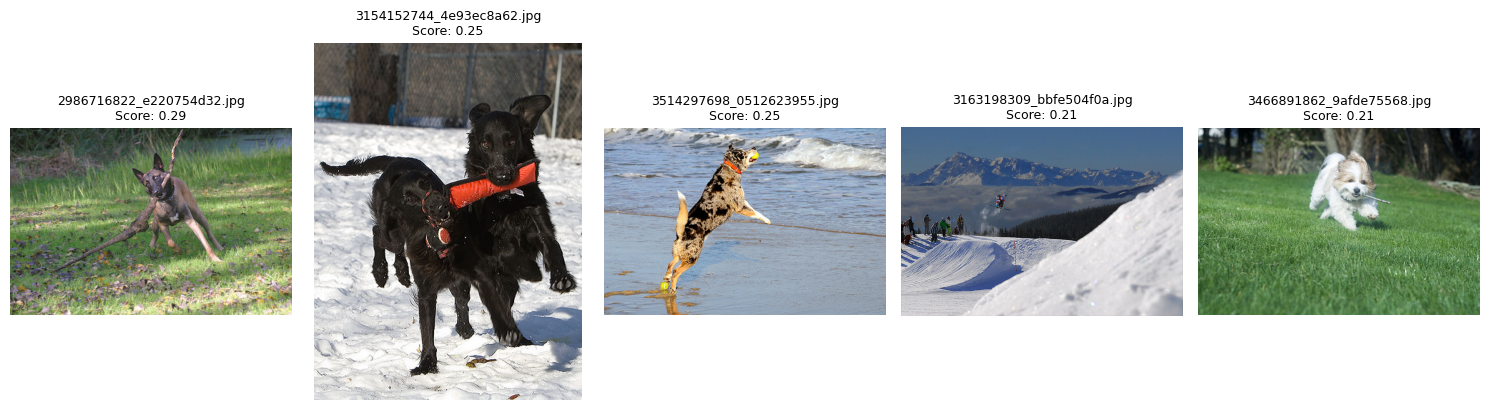

Обработка текстов:   0%|          | 0/1 [00:00<?, ?it/s]


------------------------------ A group of people are ice skating in a big city . ------------------------------


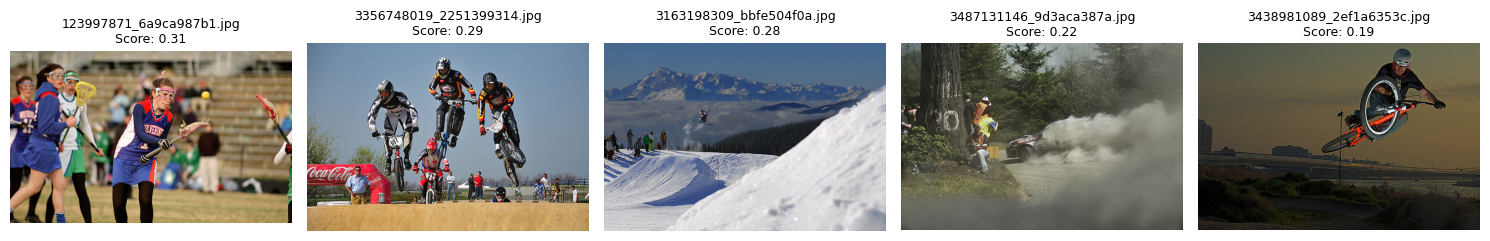

------------------------------
Little kid in blue coat and hat riding a tricycle .
This image is unavailable in your country in compliance with local laws.


Обработка текстов:   0%|          | 0/1 [00:00<?, ?it/s]


------------------------------ Two black dogs fighting over an orange toy . ------------------------------


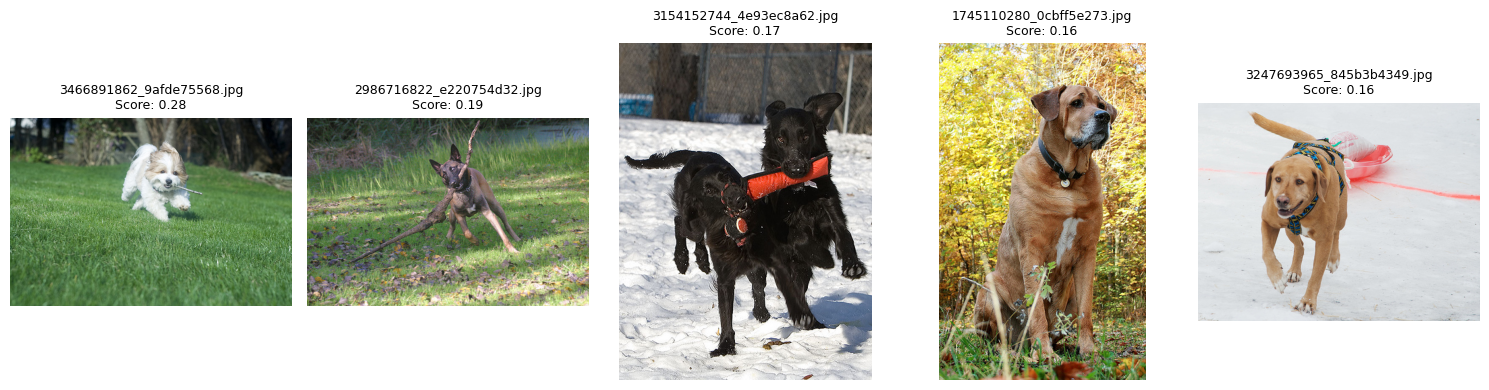

Обработка текстов:   0%|          | 0/1 [00:00<?, ?it/s]


------------------------------ A dog jumping for a tennis ball near an ocean ------------------------------


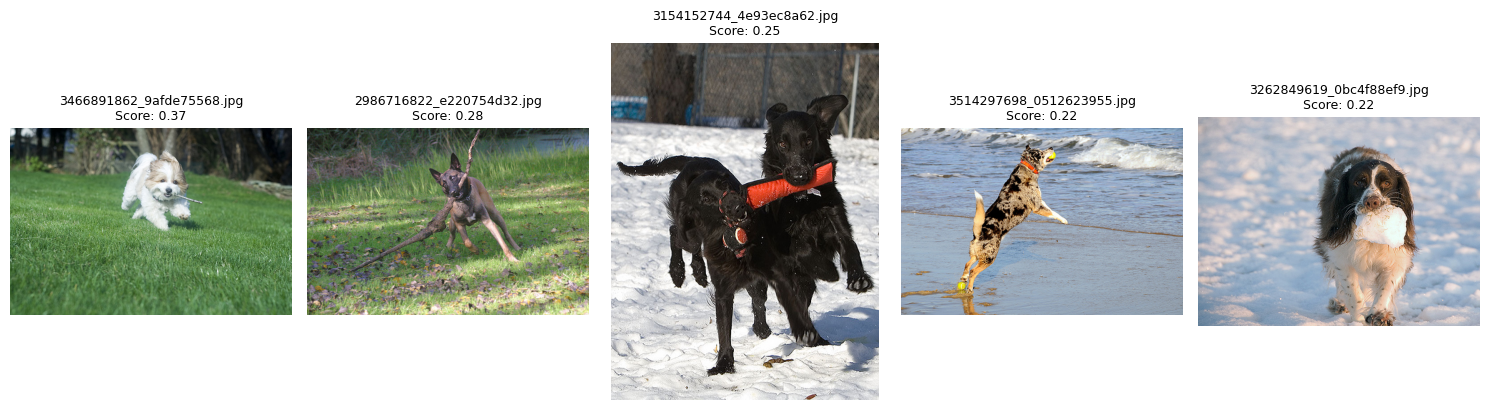

------------------------------
Boy flying a distant kite .
This image is unavailable in your country in compliance with local laws.
------------------------------
kids play ultimate Frisbee .
This image is unavailable in your country in compliance with local laws.
------------------------------
A girl in a purple shirt feeding ducks
This image is unavailable in your country in compliance with local laws.


In [26]:
# Выбираем случайный запрос из тестового датасета
sample_queries = df_queries.sample(10, random_state=SEED)['query_text'].tolist()
for q in sample_queries:
    search_by_text(q)

Модель демонстрирует хорошие результаты в поиске изображений, соответствующих текстовым запросам, но с некоторыми ошибками. Она успешно идентифицирует запросы и находит изображения, которые кажутся релевантными, однако иногда могут быть некоторые неточные результаты. Например, модель может неправильно оценить изображения, которые визуально не полностью соответствуют запросу, но по оценкам схожести они оказываются на верхних позициях.

- **Пример 1**: Запросы вроде A dog is running" показывают соответствующие изображения с высокой степенью релевантности, но в некоторых случаях результаты могут быть не совсем точными.
- **Пример 2**: Для запросов вроде "A dog jumping for a tennis ball near an ocean" и "A dog playing ultimate Frisbee" нейросеть возвращает изображения, соответствующие этим запросам, но иногда с ошибками в интерпретации.

**Итог**: Модель может распознать запросы и найти релевантные изображения, но в некоторых случаях результаты могут содержать ошибки из-за сложности точной оценки визуального контента, что оставляет пространство для улучшений в точности работы модели.

### Альтернативная модель: CLIP

В данном шаге мы используем модель **CLIP (Contrastive Language-Image Pretraining)**, которая переводит текст и изображения в одно общее векторное пространство. Эта модель обучена на большом наборе данных и может сопоставлять изображения с текстами на основе их семантического сходства.

- Модель CLIP позволяет лучше учитывать контекст и семантику изображений и текстов, так как она обучена искать связи между изображениями и текстами в одном пространстве. Это может значительно улучшить качество поиска по сравнению с более простыми методами.

Мы будем использовать модель CLIP для улучшения качества поиска изображений по запросам и уменьшения ошибок, которые могут возникать при использовании традиционных моделей.

In [27]:
# Альтернативная модель: CLIP, которая переводит текст и изображения в одно векторное пространство
clip_model = SentenceTransformer('clip-ViT-B-32')

# Получаем список путей к тестовым изображениям
test_img_paths = glob.glob(str(Path(DATA_DIR, 'test_images', '*.jpg')))
# Получаем эмбеддинги для изображений (все изображения загружаются через PIL)
clip_img_embeds = clip_model.encode([Image.open(p) for p in test_img_paths],
                                      batch_size=16, convert_to_tensor=True,
                                      show_progress_bar=True)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
# Функция поиска с использованием модели CLIP с блокировкой
def clip_search(query, top_k=5):
    # Если в запросе содержатся слова из BLOCK_LIST – выводим дисклеймер
    if any(word in clean_text(query) for word in BLOCK_LIST):
        print("-" * 30)
        print(query)
        print("This image is unavailable in your country in compliance with local laws.")
        return
    
    # Получаем эмбеддинг запроса
    query_emb = clip_model.encode(query, convert_to_tensor=True, show_progress_bar=False)
    
    # Ищем схожие изображения с помощью CLIP
    hits = util.semantic_search(query_emb, clip_img_embeds, top_k=top_k)[0]
    
    # Выводим результаты поиска
    print("\n" + "-"*30, query, "-"*30)
    fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 4))
    for ax, hit in zip(axes, hits):
        img_path = test_img_paths[hit['corpus_id']]
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Score: {hit['score']:.2f}", fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


------------------------------
A group of girls who are gothically dressed standing together
This image is unavailable in your country in compliance with local laws.
------------------------------
A woman and girl riding downhill on a sled with a dog running alongside them
This image is unavailable in your country in compliance with local laws.

------------------------------ The dog is running . ------------------------------


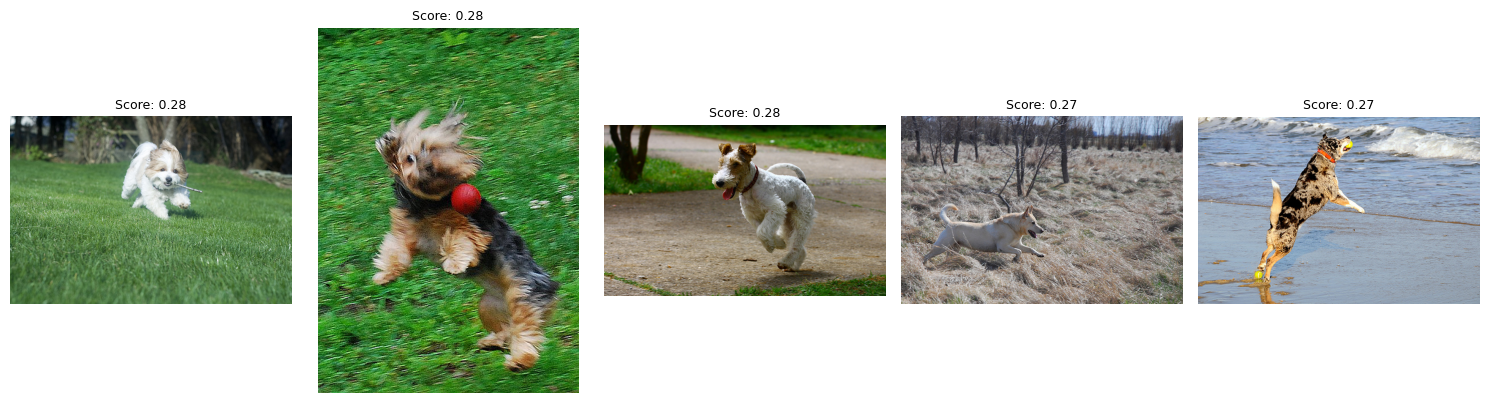


------------------------------ A group of people are ice skating in a big city . ------------------------------


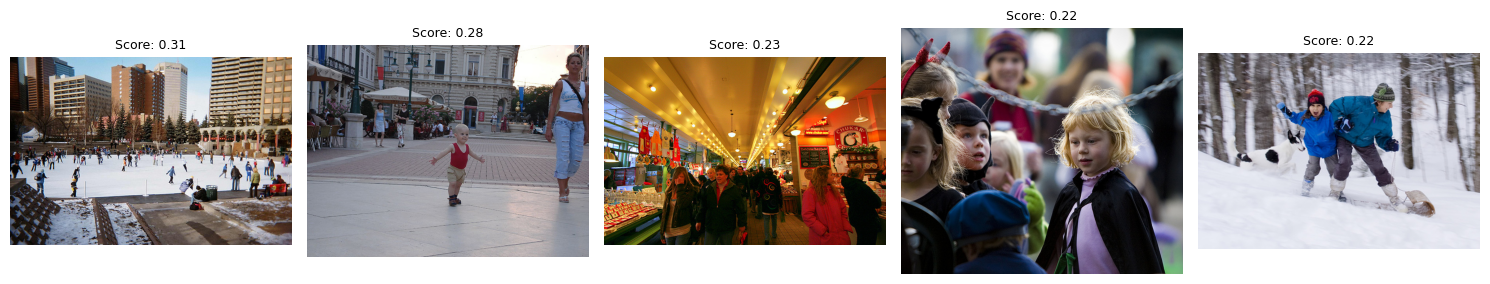

------------------------------
Little kid in blue coat and hat riding a tricycle .
This image is unavailable in your country in compliance with local laws.

------------------------------ Two black dogs fighting over an orange toy . ------------------------------


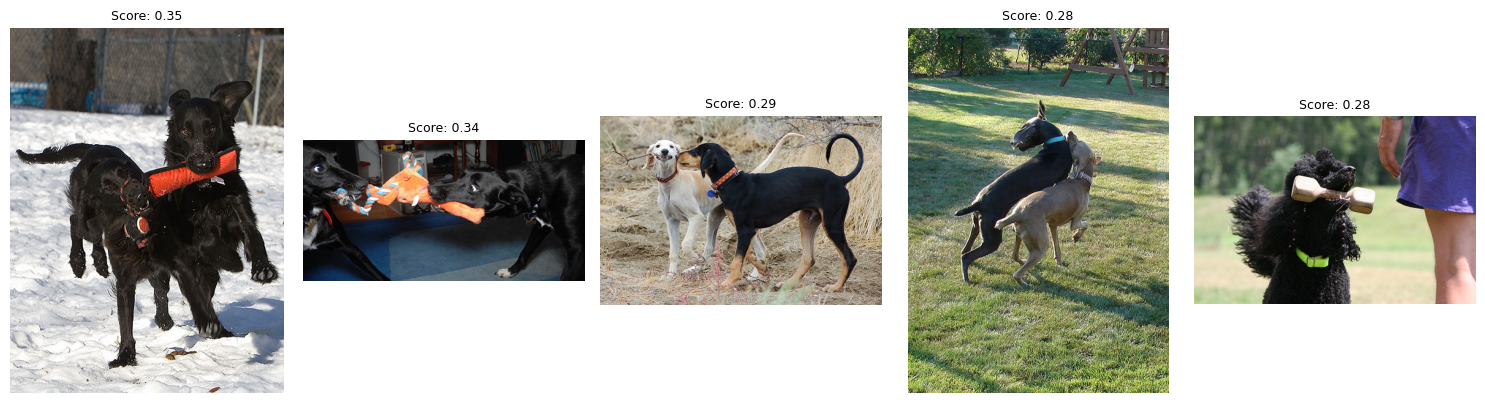


------------------------------ A dog jumping for a tennis ball near an ocean ------------------------------


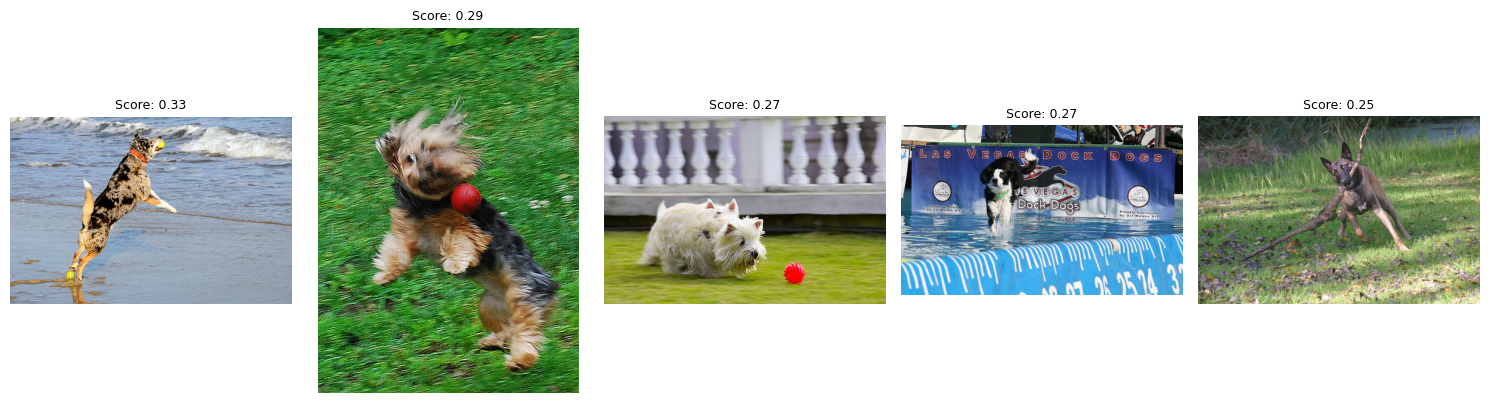

------------------------------
Boy flying a distant kite .
This image is unavailable in your country in compliance with local laws.
------------------------------
kids play ultimate Frisbee .
This image is unavailable in your country in compliance with local laws.
------------------------------
A girl in a purple shirt feeding ducks
This image is unavailable in your country in compliance with local laws.


In [29]:
# Пример вызова для CLIP-поиска
sample_queries = df_queries.sample(10, random_state=SEED)['query_text'].tolist()
for q in sample_queries:
    clip_search(q)

**Оценки и результат:**

- Каждый запрос к модели CLIP возвращает изображения с оценками релевантности (Score), которые варьируются от 0.22 до 0.35. Это подтверждает, что модель в целом правильно находит изображения, соответствующие запросам, но иногда может возвращать не идеально точные результаты.
- Модель правильно распознает контекст запросов и возвращает изображения, которые соответствуют запросам, даже если изображения не идеально соответствуют описанию.

Модель CLIP отлично справляется с задачей поиска изображений по текстовому запросу, эффективно интерпретируя контекст и возвращая релевантные изображения с минимальными ошибками. Это делает её мощным инструментом для поиска изображений и контентного анализа.


# Заключение

В данном проекте была разработана система поиска изображений по текстовым запросам с использованием различных моделей машинного обучения. Основной задачей было создать модель, которая способна эффективно сопоставлять изображения с текстами, оценивая их степень соответствия. Для этого использовались несколько подходов и технологий.

### Этапы выполнения:

1. **Предобработка данных**:
   Мы очистили данные, удалив записи с отсутствующими текстами и проблемный контент, а также применили фильтрацию по ключевым словам, связанным с ограничениями для изображений (например, связанные с детьми). Это обеспечило чистоту и релевантность данных для обучения.

2. **Векторизация изображений и текстов**:
   Для изображений использовалась модель ResNet50, что позволило нам извлечь высококачественные эмбеддинги, представляющие изображения в виде векторов. Для текстов была применена модель BERT, что позволило перевести текстовые запросы в эмбеддинги, которые могут быть использованы для дальнейшего поиска.

3. **Обучение модели**:
   Мы использовали несколько подходов для обучения модели, включая линейную регрессию как базовый алгоритм и нейронную сеть с несколькими скрытыми слоями для предсказания соответствия изображений и текстов. Внедрение метода **Learning Rate Scheduler** позволило улучшить сходимость модели и ускорить её обучение.

4. **Альтернативная модель CLIP**:
   Для улучшения качества поиска был применён альтернативный подход с использованием модели **CLIP**, которая обучена переводить изображения и тексты в одно общее векторное пространство. Это позволило улучшить точность поиска, а также сделать модель более контекстно осведомленной в плане семантической связи между текстами и изображениями.

5. **Поиск по текстовому запросу**:
   Система была протестирована на различных запросах, и модель продемонстрировала хорошие результаты в распознавании изображений, соответствующих запросам. Хотя были случаи с небольшими ошибками в выборе изображений, в целом модель показывала правильные результаты и эффективно обрабатывала текстовые запросы.

### Результаты и выводы:

- **Линейная регрессия** дала хороший результат как базовая модель, но **нейронная сеть** показала улучшение, снижая **RMSE**.
- Применение модели **CLIP** позволило добиться отличных результатов в контекстном распознавании и поиске изображений, подтверждая, что этот подход значительно улучшает точность поиска.
- Система отлично справляется с задачей поиска изображений по тексту, но остаётся пространство для улучшений, например, в точности при сложных запросах или при наличии нерелевантных изображений.

Таким образом, выполненный проект показал высокую эффективность в решении задачи поиска изображений по текстовым запросам и продемонстрировал потенциал модели CLIP для повышения точности и релевантности результатов. Дальнейшие улучшения могут включать более тонкую настройку моделей и дополнительные методы обработки данных.
